# Read in the data

In [119]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [120]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [121]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [122]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [123]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [124]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [125]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [126]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [127]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [128]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

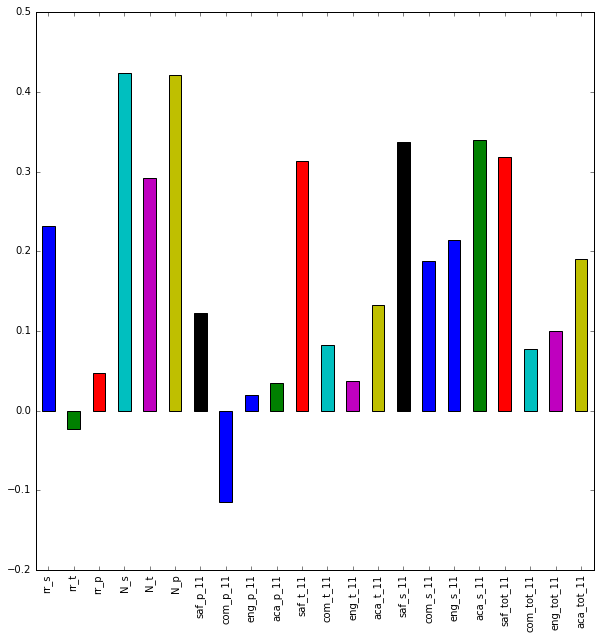

In [130]:
plt.figure(figsize=(10,10))
correlations.loc[survey_fields].plot(kind='bar')

## Observations

* The columns that correlate the most are Number of Student Respondents and Number of Parent Respondents
* Surprisingly, the communication score based on parent responses has a negative correlation when all other veriables tend to a more positive corr
* It's curious how the parents academic expectations are correlated so low with sat scores and logically students expectations are correlated much higher and teacher expectations are in the middle


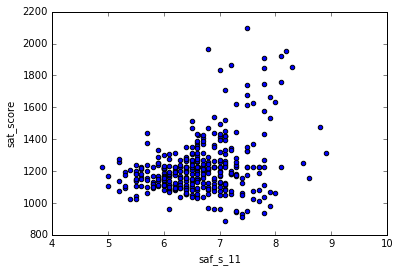

In [131]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

## Observations

* There is a brief tendency that if there is a higher score for safety ther is a higher sat_score, however datapoints are very sparse
* Correlation is really poor, I wouldn't consider this as correlated variables.

In [132]:
grouped = combined.groupby('school_dist').agg(numpy.mean)
grouped.reset_index(inplace=True)

In [133]:
grouped.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


In [134]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

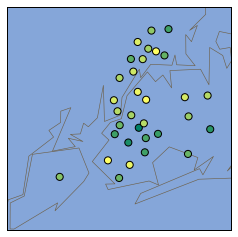

In [135]:
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.6)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = grouped['lon'].tolist()
latitudes = grouped['lat'].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=grouped['saf_s_11'], cmap='summer')


## Observations

* There's a greater concentration of low scores for safety in the Brooklyn area
* The highest scores for safety apparently are found in Manhattan
* Queens has districts with low and high safety scores

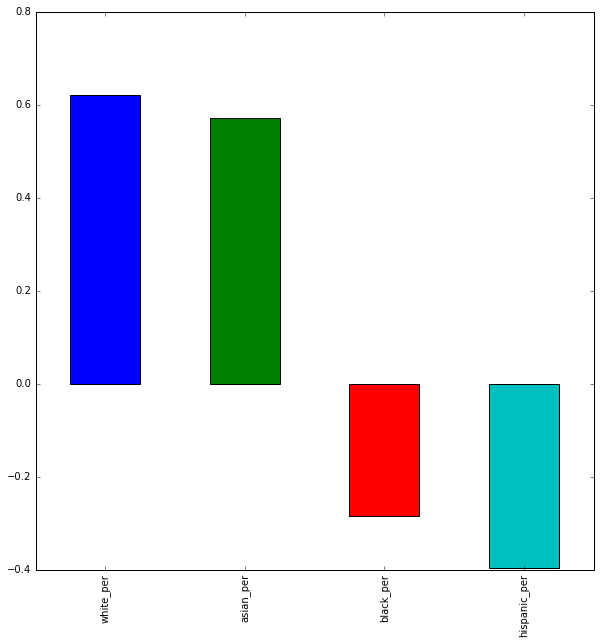

In [136]:
plt.figure(figsize=(10,10))
fields=['white_per','asian_per','black_per','hispanic_per']
correlations.loc[fields].plot(kind='bar')

## Observations
* There is a noticeable difference in the corralations between race group.
* White and Asian groups have a strong positive correlation, which means that if the school has more white and asian people, the sat scores increase.
* Black and Hispanic race groups are the other side of the coin, they have a negative correlation. This means that the more black or hispanic percentage in a school, the more the sat scores drop.

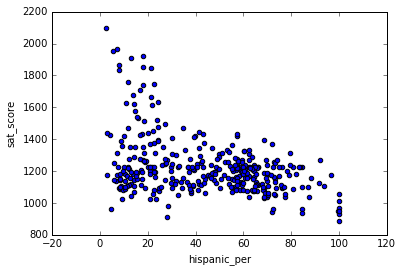

In [137]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

## Observations

* the scatter plot shows a marked negative correlation, however the're many points that show no correlation with the percentage of hispanics.
* The're schools with 100% hispanics, this means that the school is probably a spanish speaking school that teaches english and this explains the low sat scores.
* There's apparently a baseline of an average sat score of 1200 points, which is probably lower than other race groups like white and asian.

In [138]:
combined.loc[combined['hispanic_per'] > 95,'SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

## Observations

* Almost all schools mentioned that there an immigrant oriented school that accepts stundents who have Spanish as their main lenguage
* Only WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL presents itself as a normal school not oriented specifically for hispanic immigrants, however, they have a very high hispanic percentage. 

In [139]:
combined.loc[combined['hispanic_per'] < 10,'SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           B

## Observations

* A percentage of the schools with low hispanic population are top tier school with high academic standards. 
* Other schools on the list don't present any type of particularity, some are normal schools with no specific population target but may be located in specific neighborhoods that a certain race group is predominantly present. 
* Some of the schools target other types of race populations like black and asian people. 

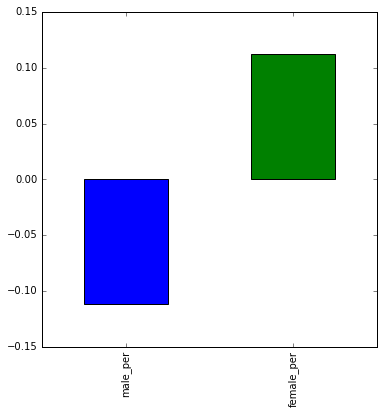

In [140]:
plt.figure(figsize=(6,6))
correlations.loc[['male_per','female_per']].plot(kind='bar')

## Observations

* There is no significant correlation between gender and sat scores
* There's a slightly positive correlation in favor of women and a negative correlation for men

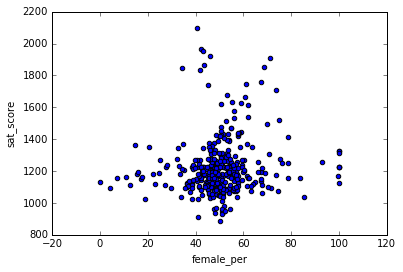

In [141]:
combined.plot.scatter(x='female_per', y='sat_score')

## Observations

* Scatter plots shows clearly the mayority of schools with a balanced percentage of women, where most data points concentrate in the middle 50 %
* Schools with highest sat scores are also near 50% female percentage
* Schools with mayority of women tend to score average in sat scores
* Schools with minority of women tend to score below average in sat scores

In [142]:
combined.loc[(combined['female_per'] > 60) & (combined['sat_score'] > 1700),'SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

## Observations

* Schools with high sat scores and hight female percentage are most likely top notch schools
* Almost all schools present oportunities to take college classes and even socially integrate with college students
* Most schools have a special and different way of theaching, they are implementing innovative ways to learn. 

In [143]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

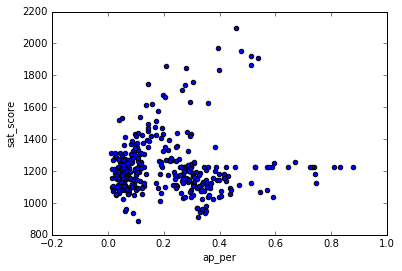

In [144]:
combined.plot.scatter(x='ap_per', y='sat_score')

In [145]:
combined[['sat_score','ap_per']].corr()

,sat_score,ap_per
sat_score,1.000000,0.057171
ap_per,0.057171,1.000000


## Observations
* There are no clear relationships between the ap test percentage and the sat score.
* Some data points does present a positive slope by the time the ap_per increases, but there is not enough data points with this patter to support any theory that the more you increase ap_per the better the sat scores

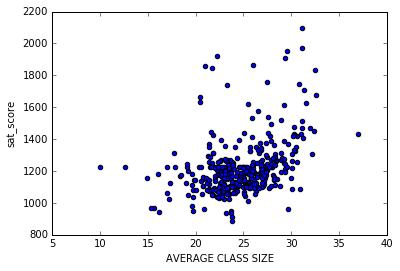

In [146]:
combined.plot.scatter(x='AVERAGE CLASS SIZE', y='sat_score')

## Observations

* There is a very surprising positive correlation between class size and sat scores.
* The fact that this is surprising is because if the class size is bigger this means that there's less attention to each individual student, therfore, you would expect for a class size with a smaller amount of students and more personalized attention to score higher is sat scores.

In [147]:
for col in combined.columns:
    print(col+'\n')

DBN

SCHOOL NAME

Num of SAT Test Takers

SAT Critical Reading Avg. Score

SAT Math Avg. Score

SAT Writing Avg. Score

sat_score

SchoolName

AP Test Takers 

Total Exams Taken

Number of Exams with scores 3 4 or 5

Demographic

School Name

Cohort

Total Cohort

Total Grads - n

Total Grads - % of cohort

Total Regents - n

Total Regents - % of cohort

Total Regents - % of grads

Advanced Regents - n

Advanced Regents - % of cohort

Advanced Regents - % of grads

Regents w/o Advanced - n

Regents w/o Advanced - % of cohort

Regents w/o Advanced - % of grads

Local - n

Local - % of cohort

Local - % of grads

Still Enrolled - n

Still Enrolled - % of cohort

Dropped Out - n

Dropped Out - % of cohort

CSD

NUMBER OF STUDENTS / SEATS FILLED

NUMBER OF SECTIONS

AVERAGE CLASS SIZE

SIZE OF SMALLEST CLASS

SIZE OF LARGEST CLASS

SCHOOLWIDE PUPIL-TEACHER RATIO

Name

schoolyear

fl_percent

frl_percent

total_enrollment

prek

k

grade1

grade2

grade3

grade4

grade5

grade6

grade7

gr

## Correlation between Survey Scores and SAT Scores

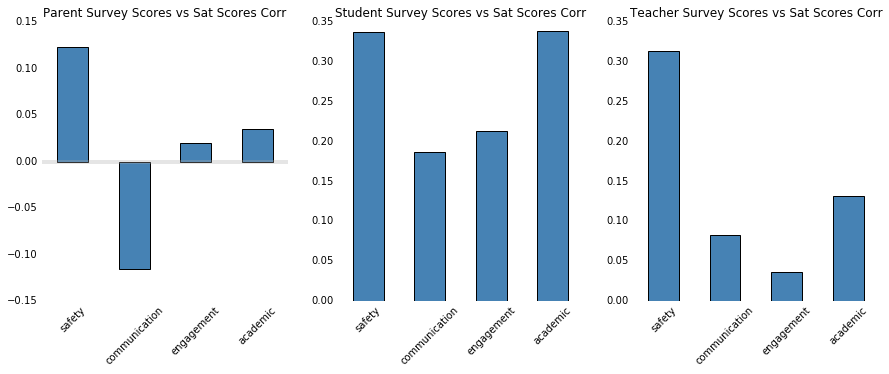

In [148]:
parent_fields = ['saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11']
student_fields = ['saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11']
teacher_fields = ['saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11']
fields = [parent_fields, student_fields, teacher_fields]
titles = ['Parent Survey Scores vs Sat Scores Corr', 'Student Survey Scores vs Sat Scores Corr','Teacher Survey Scores vs Sat Scores Corr']
tick_titles = ['safety','communication','engagement', 'academic']

fig = plt.figure(figsize=(15,5))
bar_pos = numpy.arange(4) + 0.75
tick_pos = range(1,5)
for pos in range(0,3):
    ax = fig.add_subplot(1,3,pos+1)
    ax.bar(bar_pos, correlations.loc[fields[pos]], 0.5, color='steelblue')
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.tick_params(bottom="off", top="off", left="off", right="off")
    ax.set_xticks(tick_pos)
    ax.set_title(titles[pos])
    ax.set_xticklabels(tick_titles, rotation=45)
    if pos == 0:
        ax.axhline(0, c=(171/255,171/255,171/255), alpha=0.3, linewidth=4)

## Observations

* There's a clear evidence that the survey results from the students correlates significantly more with the sat scores positively.
* It's notable that the safety survey results correlates so much with sat scores, this is probably an important factor for academic success. 
* We can also notice that the higher the communication is scored on the parent survey the less students score on the sat, which means that there's a negative correlation that's worth mentioning.

In [149]:
correlations.sort_values(ascending=False)

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS / SEATS FILLED       0.394626
female_num                              0.388631
AVERAGE CLASS SIZE                      0.381014
total_enrollment                        0.367857
NUMBER OF SECTIONS                      0.362673
aca_s_11                                0.339435
saf_s_11            

In [150]:
positive_fields = ['white_per','asian_per','AP Test Takers ','Total Exams Taken','Number of Exams with scores 3 4 or 5','N_s','N_p']
negative_fields = ['black_per','hispanic_per','ell_percent','sped_percent','frl_percent']

In [151]:
suma = correlations[positive_fields].sum() 
positive_w = correlations[positive_fields] / suma
positive_w

white_per                               0.175485
asian_per                               0.161353
AP Test Takers                          0.147898
Total Exams Taken                       0.145409
Number of Exams with scores 3 4 or 5    0.130965
N_s                                     0.119718
N_p                                     0.119172
Name: sat_score, dtype: float64

In [152]:
def school_score(val, col):
    return val * positive_w[col]

In [153]:
test = combined[positive_fields].copy()

In [154]:
for col in positive_w.index:
    test[col + '_sscore'] = test[col].apply(school_score, args=(col,))

In [155]:
test['school_name'] = combined['SCHOOL NAME']
test.head()

,white_per,asian_per,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,N_s,N_p,white_per_sscore,asian_per_sscore,AP Test Takers _sscore,Total Exams Taken_sscore,Number of Exams with scores 3 4 or 5_sscore,N_s_sscore,N_p_sscore,school_name
0,1.7,14.0,129.028846,197.038462,153.45,379.000000,151.0,0.298324,2.258938,19.083163,28.651085,20.096619,45.373256,17.994956,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES
1,2.3,29.2,39.000000,49.000000,10.00,385.000000,46.0,0.403615,4.711498,5.768039,7.125021,1.309653,46.091566,5.481907,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL
2,10.4,9.7,19.000000,21.000000,153.45,598.208333,150.0,1.825042,1.565121,2.810070,3.053580,20.096619,71.616517,17.875784,EAST SIDE COMMUNITY SCHOOL
3,1.6,9.3,129.028846,197.038462,153.45,306.000000,69.0,0.280776,1.500580,19.083163,28.651085,20.096619,36.633816,8.222861,MARTA VALLE HIGH SCHOOL
4,44.9,27.8,255.000000,377.000000,191.00,923.000000,736.0,7.879267,4.485605,37.714099,54.819038,25.014364,110.500041,87.710513,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ..."


In [156]:
sum_fields = ['white_per_sscore','asian_per_sscore','AP Test Takers _sscore','Total Exams Taken_sscore','Number of Exams with scores 3 4 or 5_sscore','N_s_sscore','N_p_sscore']
test['total_sscore'] = test[sum_fields].sum(axis=1)

In [157]:
test.head()

,white_per,asian_per,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,N_s,N_p,white_per_sscore,asian_per_sscore,AP Test Takers _sscore,Total Exams Taken_sscore,Number of Exams with scores 3 4 or 5_sscore,N_s_sscore,N_p_sscore,school_name,total_sscore
0,1.7,14.0,129.028846,197.038462,153.45,379.000000,151.0,0.298324,2.258938,19.083163,28.651085,20.096619,45.373256,17.994956,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,133.756341
1,2.3,29.2,39.000000,49.000000,10.00,385.000000,46.0,0.403615,4.711498,5.768039,7.125021,1.309653,46.091566,5.481907,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,70.891299
2,10.4,9.7,19.000000,21.000000,153.45,598.208333,150.0,1.825042,1.565121,2.810070,3.053580,20.096619,71.616517,17.875784,EAST SIDE COMMUNITY SCHOOL,118.842733
3,1.6,9.3,129.028846,197.038462,153.45,306.000000,69.0,0.280776,1.500580,19.083163,28.651085,20.096619,36.633816,8.222861,MARTA VALLE HIGH SCHOOL,114.468899
4,44.9,27.8,255.000000,377.000000,191.00,923.000000,736.0,7.879267,4.485605,37.714099,54.819038,25.014364,110.500041,87.710513,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",328.122927


In [158]:
test.loc[test['total_sscore'].sort_values(ascending=False).head().index]

,white_per,asian_per,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,N_s,N_p,white_per_sscore,asian_per_sscore,AP Test Takers _sscore,Total Exams Taken_sscore,Number of Exams with scores 3 4 or 5_sscore,N_s_sscore,N_p_sscore,school_name,total_sscore
187,21.3,60.3,2117.0,3692.0,2687.0,4768.0,2192.0,3.737826,9.729567,313.100971,536.848509,351.903649,570.817113,261.224788,BROOKLYN TECHNICAL HIGH SCHOOL,2047.362423
37,23.7,72.1,1510.0,2819.0,2648.0,3039.0,1062.0,4.158990,11.633528,223.326626,409.906811,346.796004,363.824078,126.560550,STUYVESANT HIGH SCHOOL,1486.206587
151,25.4,63.5,1190.0,2435.0,2189.0,2956.0,1314.0,4.457314,10.245895,175.999129,354.069913,286.682950,353.887455,156.591867,BRONX HIGH SCHOOL OF SCIENCE,1341.934523
276,21.2,31.7,745.0,1223.0,758.0,3330.0,2804.0,3.720278,5.114880,110.184329,177.834704,99.271666,398.662119,334.157987,MIDWOOD HIGH SCHOOL,1128.945962
304,16.8,45.7,676.0,1145.0,796.0,3393.0,1212.0,2.948145,7.373818,99.979337,166.492834,104.248346,406.204376,144.436334,BENJAMIN N. CARDOZO HIGH SCHOOL,931.683188


In [159]:
suma = correlations[negative_fields].sum() 
negative_w = correlations[negative_fields] / suma
negative_w

black_per       0.126269
hispanic_per    0.176417
ell_percent     0.177201
sped_percent    0.199163
frl_percent     0.320950
Name: sat_score, dtype: float64

In [160]:
def school_score(val, col):
    return val * negative_w[col]

In [161]:
test2 = combined[negative_fields].copy()

In [162]:
for col in negative_w.index:
    test2[col + '_sscore'] = test2[col].apply(school_score, args=(col,))

In [163]:
test2['school_name'] = combined['SCHOOL NAME']

In [164]:
sum_fields = ['black_per_sscore','hispanic_per_sscore','ell_percent_sscore','sped_percent_sscore','frl_percent_sscore']
test2['total_negative_sscore'] = test2[sum_fields].sum(axis=1)

In [165]:
test2.loc[test2['total_negative_sscore'].sort_values(ascending=False).head().index]

,black_per,hispanic_per,ell_percent,sped_percent,frl_percent,black_per_sscore,hispanic_per_sscore,ell_percent_sscore,sped_percent_sscore,frl_percent_sscore,school_name,total_negative_sscore
176,0.0,99.8,92.9,0.2,100.0,0.000000,17.606381,16.461965,0.039833,32.095034,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,66.203213
31,8.0,84.6,86.9,6.9,97.5,1.010153,14.924848,15.398759,1.374225,31.292658,MANHATTAN ACADEMY FOR ARTS & LANGUAGE,64.000643
89,0.0,99.8,89.6,0.0,92.8,0.000000,17.606381,15.877202,0.000000,29.784192,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,63.267775
139,5.4,84.7,88.7,0.4,95.1,0.681853,14.942490,15.717721,0.079665,30.522378,KINGSBRIDGE INTERNATIONAL HIGH SCHOOL,61.944107
179,10.8,84.6,86.4,0.5,90.6,1.363706,14.924848,15.310159,0.099581,29.078101,HIGH SCHOOL OF WORLD CULTURES,60.776396


In [166]:
school_scores = test.merge(test2, how='inner')

In [167]:
school_scores['sscore'] = school_scores['total_sscore'] - school_scores['total_negative_sscore']

In [168]:
school_scores.loc[school_scores['sscore'].sort_values(ascending=False).head().index,['school_name','sscore']]

,school_name,sscore
189,BROOKLYN TECHNICAL HIGH SCHOOL,2028.291302
37,STUYVESANT HIGH SCHOOL,1475.827203
153,BRONX HIGH SCHOOL OF SCIENCE,1329.208243
278,MIDWOOD HIGH SCHOOL,1107.522769
306,BENJAMIN N. CARDOZO HIGH SCHOOL,910.735739


In [169]:
combined['sscore'] = school_scores['sscore']

In [170]:
grouped = combined.groupby('school_dist').agg(numpy.mean)
grouped.reset_index(inplace=True)

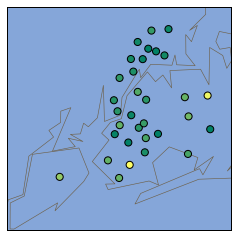

In [171]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.6)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = grouped['lon'].tolist()
latitudes = grouped['lat'].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=grouped['sscore'], cmap='summer')

In [175]:
grouped['sscore'].sort_values(ascending=False).head()

21    481.943347
25    452.664434
30    302.796706
27    247.179159
20    225.490379
Name: sscore, dtype: float64

## Observations

* The districts with the best school score (sscore) based of different criteria. like safety, AP tests and race percentaje, which highly correlate to better SAT scores.
* Districts with the best sscore are surprisingly in Queens and Brooklyn, Manhattan actually is below the previous bouroughs.
* Highest sscore is found in Brooklyn School District 21.
* Worst districts with low sscores are found in Manhattan, this is rare since schools here are considered to be top notch schools. 